## Bayesian Optimisation Over Molecules ##

An example notebook for Bayesian optimisation on a molecular dataset using a Tanimoto fingerprint kernel and the photoswitch dataset

Paper: https://pubs.rsc.org/en/content/articlelanding/2022/sc/d2sc04306h

Code: https://github.com/Ryan-Rhys/The-Photoswitch-Dataset

A key aspect of this Bayesian optimisation loop is that the queried molecules, $\mathbf{x^*}$. are drawn from a discrete set of heldout molecules, $\mathcal{D}_{\text{heldout}}$. Such situations may arise in virtual screening campaigns where one wishes to select a molecule for synthesis from a virtual library. In this case the acquisition function is evaluated on a discrete set and the maximum of the set is taken as the proposed candidate at each iteration of Bayesian optimisation.

In [9]:
"""Imports."""

import time
import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.model_selection import train_test_split

from gauche.dataloader import MolPropLoader

We define our model. See

https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

for further examples!

In [10]:
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel

# We define our custom GP surrogate model using the Tanimoto kernel

class TanimotoGP(SingleTaskGP):

    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y, likelihood=GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(base_kernel=TanimotoKernel())
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

We define helper functions for the Bayesian optimisation loop. In particular the acquisition function optimisation procedure is framed so as to take the maximum over a discrete set of heldout molecules.

In [11]:
def initialize_model(train_x, train_obj, state_dict=None):
    """
    Initialise model and loss function.

    Args:
        train_x: tensor of inputs
        train_obj: tensor of outputs
        state_dict: current state dict used to speed up fitting

    Returns: mll object, model object
    """

    # define model for objective
    model = TanimotoGP(train_x, train_obj).to(train_x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)

    return mll, model


def optimize_acqf_and_get_observation(acq_func, heldout_inputs, heldout_outputs):
    """
    Optimizes the acquisition function, and returns a new candidate and an observation.

    Args:
        acq_func: Object representing the acquisition function
        heldout_points: Tensor of heldout points

    Returns: new_x, new_obj
    """

    # Loop over the discrete set of points to evaluate the acquisition function at.
    acq_vals = []
    for i in range(len(heldout_outputs)):
        acq_vals.append(acq_func(heldout_inputs[i].unsqueeze(-2)))  # use unsqueeze to append batch dimension

    # observe new values
    acq_vals = torch.tensor(acq_vals)
    best_idx = torch.argmax(acq_vals)
    new_x = heldout_inputs[best_idx].unsqueeze(-2)  # add batch dimension
    new_obj = heldout_outputs[best_idx].unsqueeze(-1)  # add output dimension

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:best_idx], heldout_inputs[best_idx+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:best_idx], heldout_outputs[best_idx+1:]), axis=0)

    return new_x, new_obj, heldout_inputs, heldout_outputs


def update_random_observations(best_random, heldout_inputs, heldout_outputs):
    """
    Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point from the heldout set, observing its value, and updating the list.

    Args:
        best_random: List of best random values observed so far
        heldout_inputs: Tensor of inputs
        heldout_outputs: Tensor of output values

    Returns: best_random, float specifying the objective function value.
    """

    # Take a random sample by permuting the indices and selecting the first element.
    index = torch.randperm(len(heldout_outputs))[0]
    next_random_best = heldout_outputs[index]
    best_random.append(max(best_random[-1], next_random_best))

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:index], heldout_inputs[index+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:index], heldout_outputs[index+1:]), axis=0)

    return best_random, heldout_inputs, heldout_outputs

Run the Bayesian optimisation loop, comparing the analytic (sequential) expected improvement acquisition funciton with a random policy.

Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).

Trial  1 of 20 ....................
Trial  2 of 20 ....................
Trial  3 of 20 ....................
Trial  4 of 20 ....................
Trial  5 of 20 ....................
Trial  6 of 20 ....................
Trial  7 of 20 ....................
Trial  8 of 20 ....................
Trial  9 of 20 ....................
Trial 10 of 20 ....................
Trial 11 of 20 ....................
Trial 12 of 20 ....................
Trial 13 of 20 ....................
Trial 14 of 20 ....................
Trial 15 of 20 ....................
Trial 16 of 20 ....................
Trial 17 of 20 ....................
Trial 18 of 20 ....................
Trial 19 of 20 ....................
Trial 20 of 20 ....................

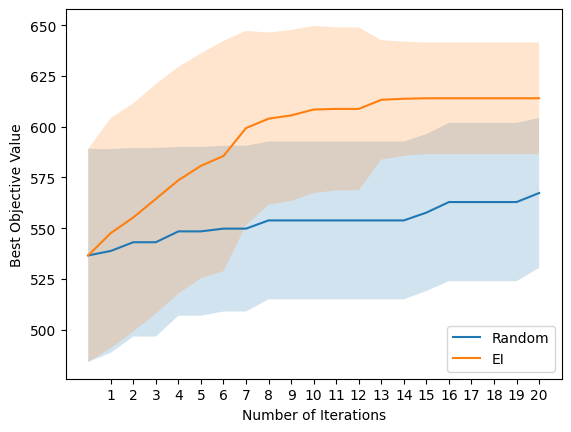

In [12]:
# Bayesian optimisation experiment parameters, number of random trials, split size, batch size
# and number of iterations of Bayesian optimisation.

N_TRIALS = 20
holdout_set_size = 0.95
N_ITERS = 20
verbose = False

# Load the Photoswitch dataset
loader = MolPropLoader()
loader.load_benchmark("Photoswitch")

# We use the fragprints representations (a concatenation of Morgan fingerprints and RDKit fragment features)
loader.featurize('ecfp_fragprints')
X = loader.features
y = loader.labels

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

best_observed_all_ei, best_random_all = [], []

# average over multiple random trials (each trial splits the initial training set for the GP in a random manner)
for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_random = [], []

    # Generate initial training data and initialize model
    train_x_ei, heldout_x_ei, train_y_ei, heldout_y_ei = train_test_split(X, y, test_size=holdout_set_size, random_state=trial)
    best_observed_value_ei = torch.tensor(np.max(train_y_ei))

    # Convert numpy arrays to PyTorch tensors and flatten the label vectors
    train_x_ei = torch.tensor(train_x_ei.astype(np.float64))
    heldout_x_ei = torch.tensor(heldout_x_ei.astype(np.float64))
    train_y_ei = torch.tensor(train_y_ei)
    heldout_y_ei = torch.tensor(heldout_y_ei)

    # The initial heldout set is the same for random search
    heldout_x_random = heldout_x_ei
    heldout_y_random = heldout_y_ei

    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)

    best_observed_ei.append(best_observed_value_ei)
    best_random.append(best_observed_value_ei)

    # run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ITERS + 1):

        t0 = time.time()

        # fit the model
        fit_gpytorch_model(mll_ei)

        # Use analytic acquisition function for batch size of 1.
        EI = ExpectedImprovement(model=model_ei, best_f=(train_y_ei.to(train_y_ei)).max())

        new_x_ei, new_obj_ei, heldout_x_ei, heldout_y_ei = optimize_acqf_and_get_observation(EI,
                                                                                             heldout_x_ei,
                                                                                             heldout_y_ei)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_y_ei = torch.cat([train_y_ei, new_obj_ei])

        # update random search progress
        best_random, heldout_x_random, heldout_y_random = update_random_observations(best_random,
                                                                                     heldout_inputs=heldout_x_random,
                                                                                     heldout_outputs=heldout_y_random)
        best_value_ei = torch.max(new_obj_ei, best_observed_ei[-1])
        best_observed_ei.append(best_value_ei.squeeze())

        # reinitialise the model so it is ready for fitting on the next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei,
            train_y_ei,
            model_ei.state_dict(),
        )

        t1 = time.time()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}), "
                f"time = {t1 - t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(torch.hstack(best_observed_ei))
    best_random_all.append(torch.hstack(best_random))

# Define a confience interval function for plotting.
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

iters = np.arange(N_ITERS + 1)
y_ei = np.asarray(torch.stack(best_observed_all_ei))
y_rnd = np.asarray(torch.stack(best_random_all))

y_rnd_mean = y_rnd.mean(axis=0)
y_ei_mean = y_ei.mean(axis=0)
y_rnd_std = y_rnd.std(axis=0)
y_ei_std = y_ei.std(axis=0)

lower_rnd = y_rnd_mean - y_rnd_std
upper_rnd = y_rnd_mean + y_rnd_std
lower_ei = y_ei_mean - y_ei_std
upper_ei = y_ei_mean + y_ei_std

plt.plot(iters, y_rnd_mean, label='Random')
plt.fill_between(iters, lower_rnd, upper_rnd, alpha=0.2)
plt.plot(iters, y_ei_mean, label='EI')
plt.fill_between(iters, lower_ei, upper_ei, alpha=0.2)
plt.xlabel('Number of Iterations')
plt.ylabel('Best Objective Value')
plt.legend(loc="lower right")
plt.xticks(list(np.arange(1, 21)))
plt.show()

EI outperforms random search in terms of selecting molecules with high E isomer pi-pi* transition wavelength! It should be noted that the true objective for photoswitch optimisation would consider all transition wavelengths as well as the thermal half-life and this will hopefully be included in a future notebook!